In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

%matplotlib inline

## Graphs in PyTorch

PyTorch internally tracks the operations done on all matrices within a series of operations and creates a [*graph*](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#computational-graph), this graph stores the required information while *propagating forward*, and calculates the gradients for each matrix *via chain rule* in *backpropagation*

## Example

### The Dataset

We're going to use a simple dataset for the purpose of demonstration.

The dataset from [Github gists](https://gist.github.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb) has three columns:
1. Gender (Male/Female)
2. Height (inches)
3. Weight (pounds)

In this exercise we want to predict the person's weight, given his height and gender

In [2]:
raw = pd.read_csv(
    filepath_or_buffer="https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv"
)

In [3]:
raw.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [4]:
raw.describe()

,Height,Weight
count,10000.000000,10000.000000
mean,66.367560,161.440357
std,3.847528,32.108439
min,54.263133,64.700127
25%,63.505620,135.818051
50%,66.318070,161.212928
75%,69.174262,187.169525
max,78.998742,269.989699


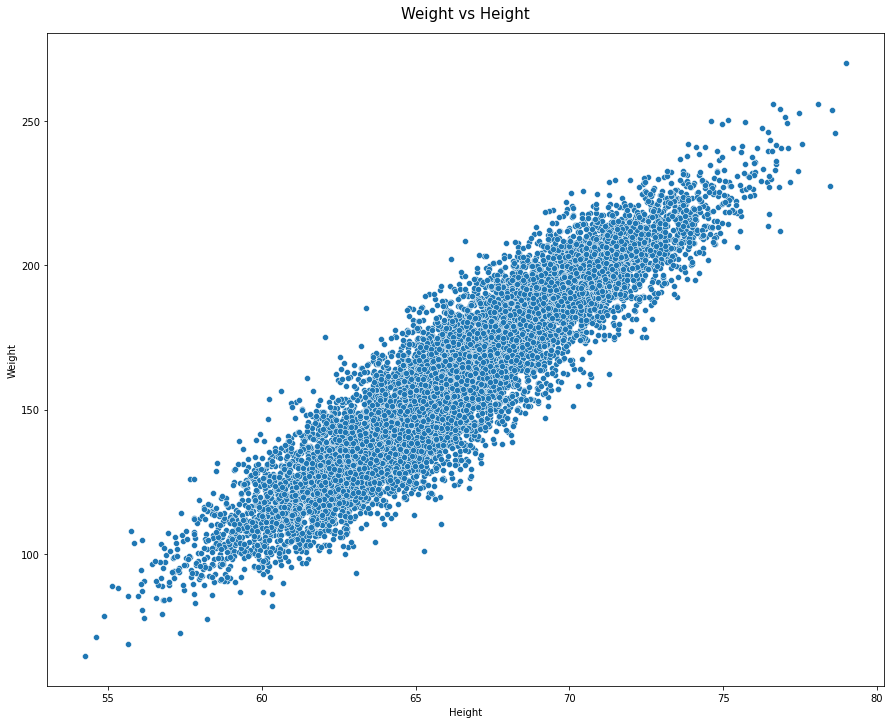

In [5]:
fig, ax = plt.subplots(figsize=(15, 12))

sns.scatterplot(data=raw, x="Height", y="Weight")
ax.set_title(label="Weight vs Height", fontdict=dict(size=15), pad=15)

plt.show()

#### Preprocessing

In [6]:
data = raw.copy(deep=True)

In [7]:
data = pd.get_dummies(data=data, columns=["Gender"])
data.head()

,Height,Weight,Gender_Female,Gender_Male
0,73.847017,241.893563,0,1
1,68.781904,162.310473,0,1
2,74.110105,212.740856,0,1
3,71.730978,220.042470,0,1
4,69.881796,206.349801,0,1


In [8]:
height_scaler = StandardScaler()
weight_scaler = StandardScaler()

data["Height"] = height_scaler.fit_transform(data["Height"].to_numpy().reshape(-1, 1)).flatten()
data["Weight"] = weight_scaler.fit_transform(data["Weight"].to_numpy().reshape(-1, 1)).flatten()

In [9]:
data.head()

,Height,Weight,Gender_Female,Gender_Male
0,1.944061,2.505797,0,1
1,0.627537,0.027101,0,1
2,2.012443,1.597806,0,1
3,1.394060,1.825222,0,1
4,0.913421,1.398750,0,1


#### Vectorisation &  Train Test Split

In [10]:
X = data["Height"]
y = data["Weight"]

In [11]:
X.head()

0    1.944061
1    0.627537
2    2.012443
3    1.394060
4    0.913421
Name: Height, dtype: float64

In [12]:
y.head()

0    2.505797
1    0.027101
2    1.597806
3    1.825222
4    1.398750
Name: Weight, dtype: float64

In [13]:
X = X.to_numpy()
y = y.to_numpy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000,), (8000,), (2000,), (2000,))

In [16]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [17]:
X_train.shape, X_test.shape

(torch.Size([8000]), torch.Size([2000]))

In [18]:
X_train, X_test = X_train.unsqueeze(1), X_test.unsqueeze(1)
X_train.shape, X_test.shape

(torch.Size([8000, 1]), torch.Size([2000, 1]))

### Creating the Model Manually

$$
y = X \cdot W + b
$$

Where:
- y is the predicted weight: (n, )
- X is the given height: (n, 1)
- W is the weight matrix: (1, 1)
- b is the bias: (1, 1)

In [19]:
batch_size = 32

#### Sample Forward Propagation

#### `requires_grad`

In order to track the operations and calculate the gradients of a matrix, you need to let PyTorch know by enabling the `requires_grad` argument when creating a tensor

In [20]:
W = torch.randn((1, 1), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

In [21]:
X_train_sample, y_train_sample = X_train[:batch_size], y_train[:batch_size]

In [22]:
X_train_sample.shape, y_train_sample.shape

(torch.Size([32, 1]), torch.Size([32]))

In [23]:
output_sample = torch.matmul(X_train_sample, W) + torch.matmul(X_train_sample, b)

In [24]:
output_sample.shape

torch.Size([32, 1])

#### Loss Function

In [25]:
def mse(output: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    residuals = target - output
    return torch.mean(torch.square(residuals))

In [26]:
loss = mse(output=output_sample, target=y_train_sample)

#### Backward Propagation

Once you calcualte the loss based on *previous operations*, that involved matrices with `requires_grad=True`, PyTorch will automatically:
1. Backpropagate the loss
2. Compute the gradient for each matrix by chain rule

In [27]:
loss.backward()

#### Accesssing the Gradients

Each matrix that required grad has three main functions related to gradients:
1. `grad`: The signed value of the gradient (magnitude and direction) for that latest backward pass
2. `grad_fn`: The function that needs to be derived
3. `grad.zero_`: A method to reset the gradients, this needs to be done after every backward pass and weight update, otherwise PyTorch will accumulate gradients

**Remember**: When a gradient is going:
- Upwards (positive): We need to **decrease** the value of the weight
- Downwards (negative): We need to **increase** the value of the weight

In [28]:
W.grad

tensor([[-3.8159]])

In [29]:
output_sample.grad_fn

In [30]:
W.grad.zero_(), b.grad.zero_()

(tensor([[0.]]), tensor([[0.]]))

#### Full Training (Manual)

##### Hyperparams

In [31]:
epochs = 15
lr = 1e-5

##### Training

In [32]:
W = torch.randn((1, 1), requires_grad=True)
b = torch.randn((1, 1), requires_grad=True)

for epoch in range(epochs):
    epoch_loss = 0
    for sample_index in range(len(X_train)):
        inputs = X_train[sample_index]
        target = y_train[sample_index]
        
        output = torch.matmul(inputs, W) + torch.matmul(inputs, b)
        
        loss = mse(output=output, target=target)
        
        loss.backward()
        
        # While updating weights, we want to PyTorch to stop following the graph operations
        with torch.no_grad():
            # Set learning rate to 1e-5
            W -= W.grad * lr
            b -= W.grad * lr
            
            W.grad.zero_()
            b.grad.zero_()
            
        epoch_loss += loss.item()
        
    
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss / len(X_train)}")

Epoch 1: Loss = 0.4752343687319351
Epoch 2: Loss = 0.31890000818040576
Epoch 3: Loss = 0.23644950606520201
Epoch 4: Loss = 0.19296266592042394
Epoch 5: Loss = 0.170023960349644
Epoch 6: Loss = 0.15792303103836097
Epoch 7: Loss = 0.15153845538930594
Epoch 8: Loss = 0.14816907227758228
Epoch 9: Loss = 0.14639052455030646
Epoch 10: Loss = 0.1454512934409418
Epoch 11: Loss = 0.14495490448983162
Epoch 12: Loss = 0.144692451205369
Epoch 13: Loss = 0.14455352717805375
Epoch 14: Loss = 0.1444798435816695
Epoch 15: Loss = 0.14444072006146286


##### Evaluation

In [33]:
predictions = torch.matmul(X_test, W) + torch.matmul(X_test, b)

/tmp/ipykernel_167746/2238216407.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


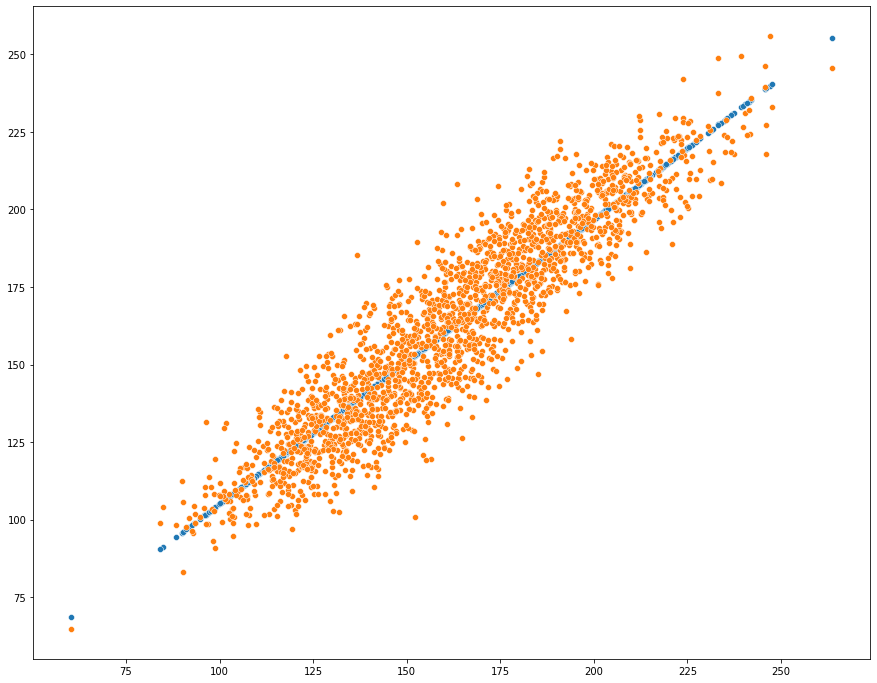

In [34]:
predictions = weight_scaler.inverse_transform(predictions.detach().numpy())
actual = weight_scaler.inverse_transform(y_test.detach().numpy().reshape((-1, 1)))
inputs = weight_scaler.inverse_transform(X_test.numpy().reshape((-1, 1)))

fig, ax = plt.subplots(figsize=(15, 12))

sns.scatterplot(x=inputs.flatten(), y=predictions.flatten(), ax=ax)
sns.scatterplot(x=inputs.flatten(), y=actual.flatten(), ax=ax)

fig.show()

### Model Using PyTorch Modules

#### Overall

PyTorch provides a wide array of configurable layers, optimizers, losses, and other utilities to create and train models effeciently

We'll be going through the steps in details, but overall the steps is as follow:
1. Prepare the dataset as tensors, either manually or using PyTorch dataset utilities 
2. Define the model as a class, inherited from PyTorch `nn.Module`, which has internal functions for training and evaluation
3. Define the optimizer, loss, ..etc
4. Create a training script
5. Evaluate

#### Creating the Dataset

Since we previously created the dataset manually, this time we will create it via PyTorch dataset utilities

In [35]:
batch_size = 1

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([8000, 1]),
 torch.Size([8000]),
 torch.Size([2000, 1]),
 torch.Size([2000]))

The first step is we create a `TensorDataset` which is a very basic utility to create dataset object from pure PyTorch tensors, PyTorch provides other utilities for images, text, ..etc using other official packages like: `torchvision`, `torchtext`, ..etc

In [37]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

The second step is to create a `dataloader` to load the dataset as batches, while implementing shuffling, sampling, ..etc 

In [38]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

#### Create the Model

The main goal here is to extend the `nn.Module` and implement to main functions:
1. `__init__`: initialise layers, params and other required inputs, eg: latent dimension, dynamic number of layers, ..etc 
2. `forward`: define the forward propagation process and return the output, which is a special function we will use later

In [39]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        
        self.fc = nn.Linear(in_features=1, out_features=1, bias=True)
        
    def forward(self, x):
        output = self.fc(x)
        return output

Then we need to instantiate the model and move it to the GPU if available

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
model = LinearRegression()
model = model.to(device)

##### What's available in PyTorch nn.Module

###### Parameters

In [42]:
print(model.parameters())
print(list(model.parameters()))

<generator object Module.parameters at 0x7f5a36952dc0>
[Parameter containing:
tensor([[0.6259]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.6607], device='cuda:0', requires_grad=True)]


In [43]:
list(model.named_parameters())

[('fc.weight',
  Parameter containing:
  tensor([[0.6259]], device='cuda:0', requires_grad=True)),
 ('fc.bias',
  Parameter containing:
  tensor([-0.6607], device='cuda:0', requires_grad=True))]

###### Training / Evaluation mode

Switch between training mode and evaluation mode.

In trainig mode PyTorch will keep track of the weights and gradients

In evaluation mode PyTorch will run more effeciently on evaluation and won't track operations

In [44]:
model.train()

model.training

True

In [45]:
model.eval()


model.training

False

The forward method is a special method, where you can call the instance of your module and pass it the input

```python
output = model(inputs)
```

#### Define Optimizer and Loss

Loss function provided by PyTorch are self explanatory and don't include alot more that was covered before, except for more configuration

Optimizers are implementation of common optimizers eg: `SGD`, `Adam`, `RMSProp`, ..etc
They are resposbile for tracking the gradients and weights, and update accordingly. 
Although we're going to use them in a simple manner for now, they can do more.

Most importantly we call `optimizer.step()` to update the weights of the matrices



In [46]:
learning_rate = 1e-4

In [47]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

#### Training

Similar to the last manual example, we're going to manually create a `for-loop` to iterate over epochs and batches

In [48]:
epochs = 10

In [49]:
# Ensure the model is in training mode
model.train()

# Iterate over epochs
for epoch in range(epochs):
    # Track loss per epoch
    epoch_loss = 0
    # For each epoch, go through all batches
    for batch in train_loader:
        # IMPORTANT: set the optimizer gradient to zero, to avoid gradient accumulation
        optimizer.zero_grad()
        
        # Each batch is a list of tensors,
        # as provided, index 0 is the inputs and index 1 is the target
        inputs, target = batch
        
        # Since our model is on the GPU, we need to move the tensors to GPU as well
        inputs, target = inputs.to(device), target.to(device)
        
        # Here we call the forward method to get the outputs from the model
        output = model(inputs)
        
        # Compute the loss, pass the predictions first and then the actual output
        loss = criterion(output, target)
        
        # Backward propagation
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        epoch_loss += loss.item()
        
    
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss / len(train_loader.dataset)}")

/home/yazansh/hdd/shai-courses/nlp-course-notebooks/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Loss = 0.30091989586503337
Epoch 2: Loss = 0.15075858690950714
Epoch 3: Loss = 0.14465325539721766
Epoch 4: Loss = 0.1444225770604544
Epoch 5: Loss = 0.14442284115385184
Epoch 6: Loss = 0.14442731253893293
Epoch 7: Loss = 0.1444285659901329
Epoch 8: Loss = 0.14441381416661864
Epoch 9: Loss = 0.14442310947219672
Epoch 10: Loss = 0.14442241475447035
